In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn_image as isns

import torch

from denoising import (
    Environment,
)
from denoising.data.utils import load_grayscale

isns.set_context('notebook')  # this will create thicker lines and larger fonts than usual
isns.set_image(cmap='gray', despine=True)  # set the colormap and despine the axes

In [4]:
print('torch ' + torch.__version__)

torch 2.6.0+cu124


In [5]:
# загружаем переменные окружения
env = Environment(_env_file='../env')

# Теорема о свертке с помощью FFT

In [8]:
from scipy import ndimage
from scipy.signal.windows import gaussian

In [9]:
def gauss_filter_kernel(sigma, kernel_size=50, norm=True):
    gkern1d = gaussian(kernel_size, std=sigma).reshape(kernel_size, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    if norm:
        gkern2d /= gkern2d.sum()
    return gkern2d

In [10]:
def dft2d(x: np.ndarray, vis: bool = False) -> np.ndarray:
    fft = np.fft.fft2(x)
    fft_centered = np.fft.fftshift(fft)
    if vis:
        return np.log(1 + np.abs(fft_centered))
    return fft_centered


def conv_dft2d(x_src: np.ndarray, w: np.ndarray, padding: str | None = 'reflect') -> np.ndarray | torch.Tensor:
    x = np.copy(x_src)

    # apply padding
    if padding is not None:
        pad_width = [(w.shape[0], w.shape[0]), (w.shape[1], w.shape[1])] + [(0, 0)] * (x.ndim - 2)
        x = np.pad(x, pad_width, mode=padding)

    w_large = np.zeros_like(x)
    w_large[: w.shape[0], : w.shape[1], ...] = w

    x_fft = dft2d(x)
    w_fft = dft2d(w_large)

    convolved_fft = x_fft * w_fft

    res = np.fft.ifft2(np.fft.ifftshift(convolved_fft)).real

    # pad back
    if padding is not None:
        slices = []
        for p1, p2 in pad_width:
            if p1 == p2 == 0:
                slices.append(slice(None))
                continue
            slices.append(slice(p1, -p2))
        res = res[tuple(slices)]

    return res

In [12]:
image = load_grayscale(env.data / 'lena.png') / 255.0
kernel = gauss_filter_kernel(3)

conv_scipy = ndimage.convolve(image, kernel)
conv_dft = conv_dft2d(image, kernel)

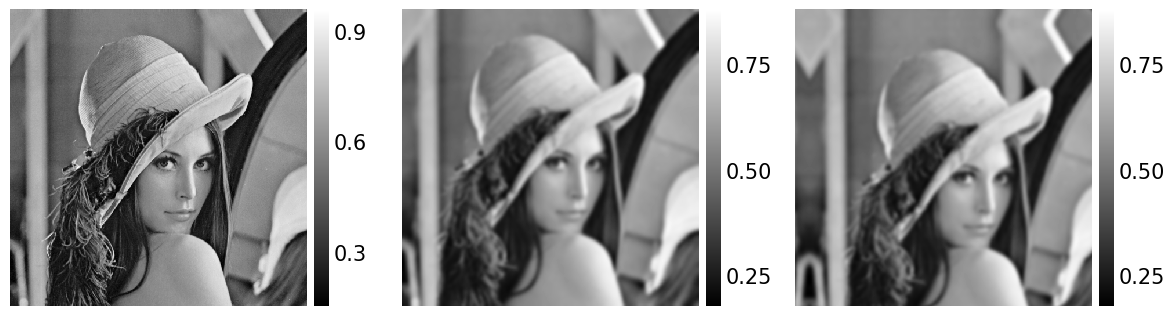

In [13]:
_ = isns.ImageGrid([
    # check dft and kernel
    # image,
    # dft2d(image, True),
    # kern,

    # check dft convolution
    image,
    conv_scipy,
    conv_dft,
], height=4)

In [14]:
np.abs(conv_scipy - conv_dft).sum(), np.abs(conv_scipy - conv_dft).max(), np.abs(conv_scipy - conv_dft).mean()

(np.float64(36871.746906608896),
 np.float64(0.6476715408998672),
 np.float64(0.140654552103458))

In [15]:
from denoising.dht_np import (
    sdht2d,
    isdht2d,
    conv2d_dht,
)

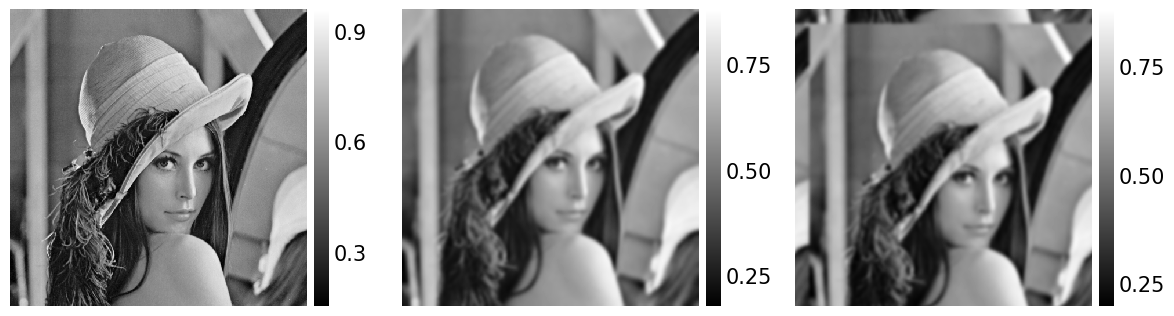

In [18]:
conv_dht = conv2d_dht(image, kernel)

_ = isns.ImageGrid([
    # validate dht-idht
    # image,
    # sdht2d(image),  # not suited for visualization
    # isdht2d(sdht2d(image)),

    # validate convolution theorem
    image,
    conv_scipy,
    conv_dht,
], height=4)

In [19]:
diff = np.abs(image - isdht2d(sdht2d(image)))
diff.sum(), diff.max(), diff.mean()

(np.float64(4.186467839062402e-11),
 np.float64(9.43689570931383e-16),
 np.float64(1.5970107418298348e-16))

In [20]:
np.abs(conv_scipy - conv_dht).sum(), np.abs(conv_scipy - conv_dht).max(), np.abs(conv_scipy - conv_dht).mean()

(np.float64(39978.613386604404),
 np.float64(0.6476715408998676),
 np.float64(0.15250630716935884))

In [21]:
np.abs(conv_dft - conv_dht).sum(), np.abs(conv_dft - conv_dht).max(), np.abs(conv_dft - conv_dht).mean()

(np.float64(4902.000121944127),
 np.float64(0.5766493230503383),
 np.float64(0.01869964646127368))

In [26]:
def conv_fft(x, y):
    def fft(c):
        # return np.fft.fft2(c)
        return np.fft.fftshift(np.fft.fft2(c))

    convolved_fft = fft(x) * fft(y)
    return np.fft.ifft2(np.fft.ifftshift(convolved_fft)).real


# version without padding
def conv_dht(x, w):
    x_dht = sdht2d(x)
    w_dht = sdht2d(w)

    x_dht_flipy = flip(x_dht, axes=1)
    w_dht_flipy = flip(w_dht, axes=1)

    z_dht = (
        even(x_dht) * even(w_dht)
        - odd(x_dht_flipy) * odd(w_dht_flipy)
        + even(x_dht_flipy) * odd(w_dht)
        + odd(x_dht) * even(w_dht_flipy)
    )
    z = isdht2d(z_dht)
    return z

In [27]:
a = np.ones((5, 5))
b = np.copy(a)

In [28]:
conv_fft(a, b), conv2d_dht(a, b, padding=None)

(array([[25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.]]),
 array([[25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.]]))